## Programming Exercise 5: Regularized Linear Regression and Bias vs. Variance

In [94]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.optimize #fmin_cg to train the linear regression
from scipy.io import loadmat
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

### Visualizing the dataset

In [95]:
datafile = 'ex5data1.mat'
mat = loadmat(datafile)
#Training set
X, y = mat['X'], mat['y']

#Cross validation set
X_val, y_val = mat['Xval'], mat['yval']

#Test set
X_test, y_test = mat['Xtest'], mat['ytest']

#Insert a column of 1's to all of the X's, as usual
X = np.insert(X,0, 1, axis = 1)
X_val = np.insert(X_val, 0, 1, axis = 1)
X_test = np.insert(X_test, 0, 1, axis = 1)

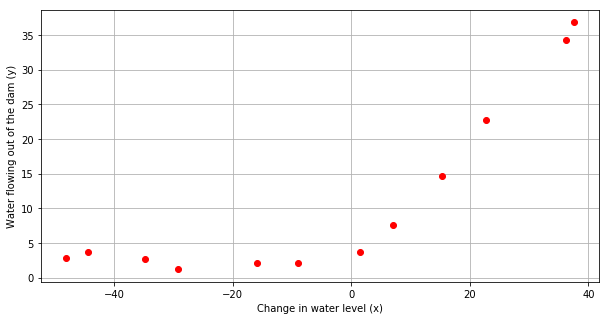

In [96]:
def plotData():
    plt.figure(figsize = (10,5))
    plt.ylabel('Water flowing out of the dam (y)')
    plt.xlabel('Change in water level (x)')
    plt.plot(X[:,1],y ,'ro')
    plt.grid(True)
    
plotData()

#### Regularized linear regression cost function

Cost Function: <br>
$$J(\theta) = \frac{1}{2m}\bigg[\sum_{i = 1}^{m}\big(h_{\theta}\big(x^{(i)}\big) - y^{(i)}\big)^2 + \lambda\sum_{j = i}^{m}\theta_j^2\bigg]$$<br>

Training Error: <br>
$$J_{train}(\theta) = \frac{1}{2m}\bigg[\sum_{i = 1}^{m}\big(h_{\theta}\big(x^{(i)}\big) - y^{(i)}\big)^2 \bigg]$$<br>

Cross Validation Error:<br>
$$J_{cv}(\theta) = \frac{1}{2m_{cv}}\bigg[\sum_{i = 1}^{m_{cv}}\big(h_{\theta}\big(x_{cv}^{(i)}\big) - y_{cv}^{(i)}\big)^2 \bigg]$$<br>


Test Error:<br>
$$J_{test}(\theta) = \frac{1}{2m_{test}}\bigg[\sum_{i = 1}^{m_{test}}\big(h_{\theta}\big(x_{test}^{(i)}\big) - y_{test}^{(i)}\big)^2 \bigg]$$<br>






Partial derivatives:<br>
for j = 0 ... (no regularisation)
$$ \frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{0} $$

for j = 1,2,3...n
$$ \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} +\frac{\lambda}{m}\theta_{j}^{2}$$

Vectorized Partial Derivative <br>
for j = 0 
$$\frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m} X^T(h-y)$$
for j = 1,2,3... n
$$\frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m} X^T(h-y) + \frac{\lambda}{m}\theta_{j}^{2}$$


                                

In [97]:
#compute the hypothesis
def h(theta, X): #Linear hypothesis function
    hyp = np.dot(X,theta)
    return(hyp)

# compute the cost function
def computeCost(theta, X, y, regu = 0): 
    m = X.shape[0]
    hyp = h(theta,X).reshape((m,1))
    J = float((1./(2 * m)) * np.dot((hyp - y).T,(hyp - y))) + (float(regu)/(2 * m)) * float(theta[1:].T.dot(theta[1:]))
    
    return J

In [98]:
# Using theta initialized at [1; 1], and lambda = 1, you should expect to 
# see an output of 303.993192
theta = np.array([[1],[1]])
regu = 1
J1 = computeCost(theta, X, y, 1)
print('Initial test:')
print('\ttheta_0 = %.0f\n\ttheta_1 = %.0f'%(theta[0],theta[1]))
print('\tRegularisation parameter = %.1f'%(regu))
print('\tCost Function = %.3f'%(J1))


Initial test:
	theta_0 = 1
	theta_1 = 1
	Regularisation parameter = 1.0
	Cost Function = 303.993


#### Regularized linear regression gradient

In [99]:
def computeGradient(theta, X, y, regu = 0):
    theta = theta.reshape((theta.shape[0],1))
    m = X.shape[0]
    #grad has same shape as Theta (2 x 1)
    hyp = h(theta, X).reshape((m,1))
    #Gradient Cost Function - bias term not reulated
    dJ = (1/m) * X.T.dot(hyp - y) + (regu / m) * np.r_[[[0]],theta[1:].reshape(-1,1)]
    #flatten the grdient (for optimise function)
    dJ = dJ.flatten()
    return(dJ)

theta = np.array([[1.],[1.]])

regu = 1
dJ =  computeGradient(theta, X, y, regu)
J1 = computeCost(theta, X, y, 1)
print('Initial test:')
print('\ttheta_0 = %.0f\n\ttheta_1 = %.0f'%(theta[0],theta[1]))
print('\tRegularisation parameter = %.1f'%(regu))
print('\tdJ_theta_0 = %.2f'%(dJ[0]))
print('\tdJ_theta_1 = %.2f'%(dJ[1]))
print('\tCost Function = %.3f'%(J1))


Initial test:
	theta_0 = 1
	theta_1 = 1
	Regularisation parameter = 1.0
	dJ_theta_0 = -15.30
	dJ_theta_1 = 598.25
	Cost Function = 303.993


### Learning curves

#### Fitting linear regression

Optimization terminated successfully.
         Current function value: 22.373906
         Iterations: 18
         Function evaluations: 28
         Gradient evaluations: 28


Optimised Results
	theta_0 = 13
	theta_1 = 0
	Regularisation parameter = 1.0
	dJ_theta_0 = 0.00
	dJ_theta_1 = -0.00
	Cost Function = 22.374


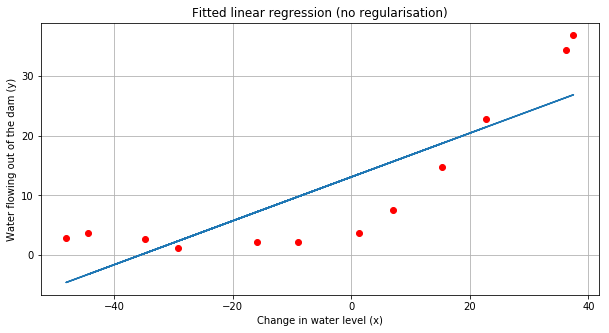

In [100]:
def optimizeTheta(Theta_initial, X, y, regu, print_output = True):
    fit_theta = scipy.optimize.fmin_cg(computeCost, x0 = Theta_initial,\
                                       fprime = computeGradient,\
                                       args = (X, y, regu),\
                                       disp = print_output,\
                                       epsilon = 1.49e-12,\
                                       maxiter = 1000)
    fit_theta = fit_theta.reshape((Theta_initial.shape[0],1))
    return (fit_theta)

theta = np.array([[1],[1]])
fit_theta = optimizeTheta(theta, X, y, 0)
dJ_opt = computeGradient(fit_theta, X, y, regu = 0)
J_opt = computeCost(fit_theta, X, y, regu = 0)
print('\n\nOptimised Results')
print('\ttheta_0 = %.0f\n\ttheta_1 = %.0f'%(fit_theta[0], fit_theta[1]))
print('\tRegularisation parameter = %.1f'%(regu))
print('\tdJ_theta_0 = %.2f'%(dJ_opt[0]))
print('\tdJ_theta_1 = %.2f'%(dJ_opt[1]))
print('\tCost Function = %.3f'%(J_opt))

plotData()
plt.plot(X[:,1],h(fit_theta,X).flatten())
plt.title('Fitted linear regression (no regularisation)')



the best fit line tels us that the model is not a good fit to the data because the data has a non-linear pattern. 

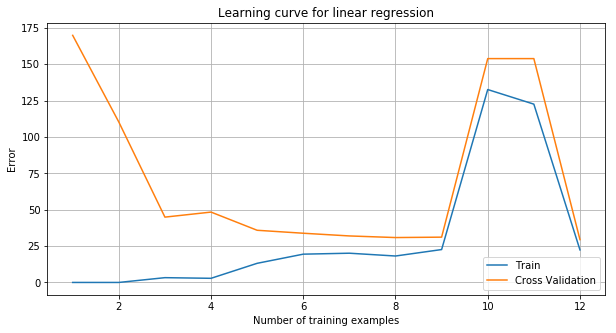

In [102]:
def plotLearningCurve():

    initial_theta = np.array([[1],[1]])
    m, error_train, error_val = [], [], []
    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        m.append(y_subset.shape[0])
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset, regu = 0,print_output = False)
        error_train.append(computeCost(fit_theta, train_subset,y_subset, regu = 0))
        error_val.append(computeCost(fit_theta, X_val, y_val,regu = 0))
        
    plt.figure(figsize = (10,5))
    plt.plot(m, error_train, label = 'Train')
    plt.plot(m, error_val, label = 'Cross Validation')
    plt.legend()
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.grid(True)
    
    
plotLearningCurve()

You can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias  problem in the model – the linear regression model is too simple and is unable to fit our dataset well."


### Polynomial regression

$$ h_{\theta} = \theta_0 + \theta_1*(WL) + \theta_2*(WL)^2 + \theta_3*(WL)^3 + ... + \theta_p*(WL)^p$$
$$ h_{\theta} = \theta_0 + \theta_1 * x_1 \theta_1 * x_2 \theta_1*x_3 ... \theta_p*x_p$$

WL = water Leverl, adn we define $x_1$ = (WL), $x_2 = (WL)^2$ ... $x_p = (WL)^p$

In [86]:
def genPolyFeatures(X, p):

    newX = X.copy()
    for i in range(p):
        dim = i + 2
        newX = np.insert(newX, newX.shape[1],np.power(newX[:,1], dim),axis = 1)
    return newX

def featureNormalize(X):
   
    Xnorm = X.copy()
    means = np.mean(Xnorm,axis = 0) #column-by-column
    Xnorm[:,1:] = Xnorm[:,1:] - means[1:]
    stds = np.std(Xnorm,axis = 0, ddof = 1)
    Xnorm[:,1:] = Xnorm[:,1:] / stds[1:]
    
    return(Xnorm, means, stds)
    

### Learning Polynomial Regression

In [87]:
#Generate an X matrix with terms up through x^8
#(7 additional columns to the X matrix)

global_d = 5
newX = genPolyFeatures(X,global_d)
newX_norm, means, stds = featureNormalize(newX)
#Find fit parameters starting with 1's as the initial guess
theta = np.ones((newX_norm.shape[1],1))
fit_theta = optimizeTheta(theta,newX_norm,y,0.)

Optimization terminated successfully.
         Current function value: 0.198053
         Iterations: 132
         Function evaluations: 251
         Gradient evaluations: 251


COMMENT: the polynomial is able to follow the data points very well - thus obtaining a very low training error. However, the polynomial fit i very complex and even drops off at the extremes. this is an indicator that the polynomial regresion is overfitting the training data and will not generalise well

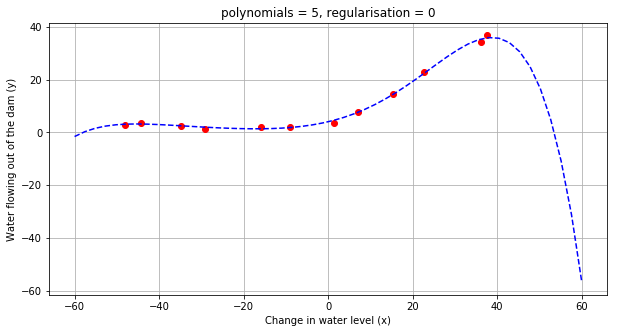

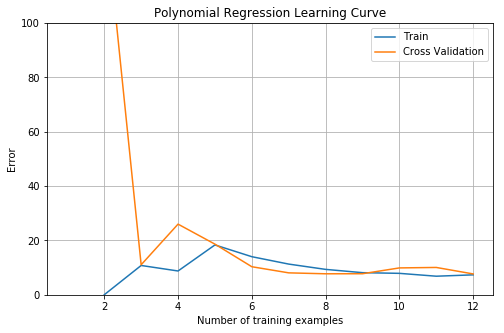

In [88]:
def plotFit(fit_theta, means, stds):

    n_points_to_plot = 50
    x_vals = np.linspace(-60, 60, n_points_to_plot)
    x_mat = np.ones((n_points_to_plot, 1))
    
    x_mat = np.insert(x_mat, x_mat.shape[1], x_vals.T,axis = 1)
    x_mat = genPolyFeatures(x_mat,len(fit_theta) - 2)
    #This is undoing feature normalization
    x_mat[:,1:] = x_mat[:,1:] - means[1:]
    x_mat[:,1:] = x_mat[:,1:] / stds[1:]
    plotData()
    plt.plot(x_vals, h(fit_theta, x_mat),'b--')

plotFit(fit_theta, means, stds)
plt.title('polynomials = 5, regularisation = 0')


def plotPolyLearningCurve(mylambda = 0):

    initial_theta = np.ones((global_d + 2,1))
    m, error_train, error_val = [], [], []
    myXval, dummy1, dummy2 = featureNormalize(genPolyFeatures(X_val,global_d))

    for x in range(1,13,1):
        train_subset = X[:x,:]
        y_subset = y[:x]
        m.append(y_subset.shape[0])
        train_subset = genPolyFeatures(train_subset, global_d)   
        train_subset, dummy1, dummy2 = featureNormalize(train_subset)
        fit_theta = optimizeTheta(initial_theta, train_subset, y_subset,regu = regu, print_output = False)
        error_train.append(computeCost(fit_theta, train_subset, y_subset, regu = regu))
        error_val.append(computeCost(fit_theta, myXval, y_val, regu = regu))
        
    plt.figure(figsize = (8,5))
    plt.plot(m,error_train,label = 'Train')
    plt.plot(m,error_val,label = 'Cross Validation')
    plt.legend()
    plt.title('Polynomial Regression Learning Curve')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.ylim([0,100])
    plt.grid(True)
    
plotPolyLearningCurve()

COMMENT: the above learning curve shows a low training error, but the cross validation error is high. 

#### Optional: Adjusting the regularization parameter

Optimization terminated successfully.
         Current function value: 7.338822
         Iterations: 14
         Function evaluations: 29
         Gradient evaluations: 29


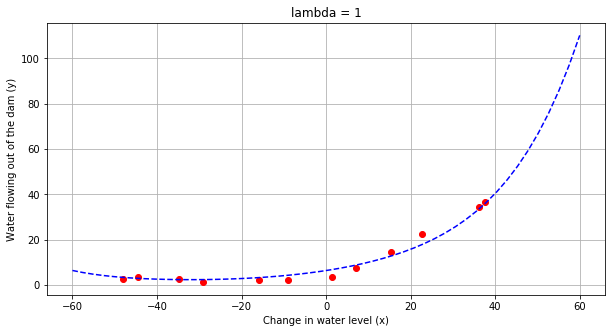

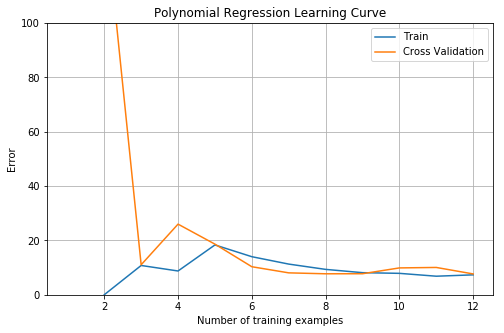

In [89]:
#Try Lambda = 1
regu = 1
theta = np.zeros((newX_norm.shape[1],1))
fit_theta = optimizeTheta(theta, newX_norm, y, 1)
plotFit(fit_theta, means, stds)
plt.title('lambda = %.0f'%(regu))
plotPolyLearningCurve(regu)

COMMENT: for $\lambda = 1$ the polynomial follows the data trend well and a the learning curve has both a low CV error and training error. this shows bias or high variance problems. in efect is ay be a good trade-off between bias and variance

         Current function value: 67.585887
         Iterations: 8
         Function evaluations: 25
         Gradient evaluations: 13


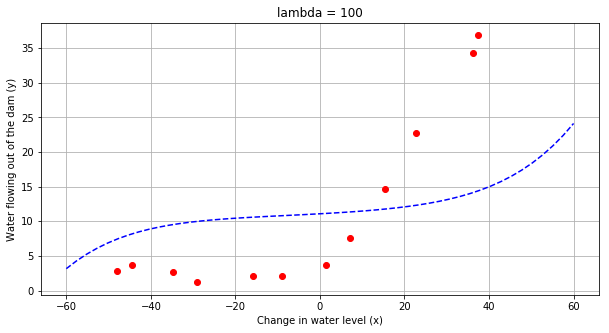

In [91]:
#Try Lambda = 100
#Note after one iteration, the lambda of 100 penalizes the theta params so hard
#that the minimizer loses precision and gives up...
#so the plot below is NOT indicative of a successful fit
regu = 100
theta = np.random.rand(newX_norm.shape[1],1)
fit_theta = optimizeTheta(theta, newX_norm, y, regu)

plotFit(fit_theta, means, stds)
plt.title('lambda = %.0f'%(regu))

for $\lambda = 100$ polynomial fit does not follow the data well. in this case there is too much regularisation adn the data is unable to fit the training data.

### Selecting $\lambda$ using a cross validation set

In [92]:
#lambdas = [0., 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1., 3., 10.]
lambdas = np.linspace(0,5,20)
errors_train, errors_val = [], []
for mylambda in lambdas:
    newXtrain = genPolyFeatures(X, global_d)
    newXtrain_norm, dummy1, dummy2 = featureNormalize(newXtrain)
    newXval = genPolyFeatures(X_val, global_d)
    newXval_norm, dummy1, dummy2 = featureNormalize(newXval)
    init_theta = np.ones((newX_norm.shape[1],1))
    fit_theta = optimizeTheta(theta, newXtrain_norm, y, mylambda,False)
    errors_train.append(computeCost(fit_theta, newXtrain_norm, y, regu = mylambda))
    errors_val.append(computeCost(fit_theta, newXval_norm, y_val, regu = mylambda))

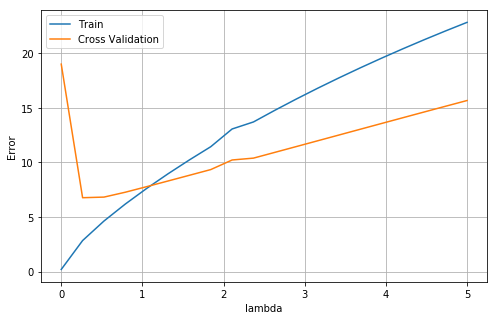

In [93]:
plt.figure(figsize=(8,5))
plt.plot(lambdas, errors_train, label = 'Train')
plt.plot(lambdas, errors_val, label = 'Cross Validation')
plt.legend()
plt.xlabel('lambda')
plt.ylabel('Error')
plt.grid(True)

a good value for $\lambda$ sould be around 3. due to randomness in the raining and validation splits of the data set, the CV error can somtimes be lower that the training error.